# Stress Signal Classification with Convolutional Neural Networks

**Author:** [Mark Goertz](https://github.com/markgoertz)<br>
**Date created:** 2024/04/04<br>
**Last modified:** 2022/04/05<br>
**Description:** Training a Convolutional model to classify stress signals produced by exposure to certain stimuli.

## Setup and Data Downloads
First, lets install our dependencies:

In [144]:
!pip install os -q
!pip install pandas -q
!pip install matplotlib -q

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
MAIN_PATH = 'D:/Master of Applied IT' 
DATA_SUBPATH = '/data'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'
PROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/processed/WESAD'

This Python script is part of a data preprocessing pipeline, for a machine learning task. The script is designed to handle data from multiple folders and multiple files within each folder.

The `minfolder` and `maxfolder` variables define the range of folders to be processed. The `folders` list generates a list of folder names in the format 'S2', 'S3', ..., 'S17'. This assumes that the folders are named in this specific format of the `WESAD` dataset.

The `final_columns` dictionary defines the final column names for each type of data file (`'ACC'`, `'EDA'`, `'HR'`, `'TEMP'`). Each key-value pair in the dictionary corresponds to a specific type of data file and its associated columns.

The `names` dictionary defines the column names for each type of data file in the `raw data`. This is used to map the raw data columns to the final column names defined in final_columns.

The `desired_signals` list contains the names of the data files to be processed. This list is used to filter out any `unwanted data files` in the folders.

Finally, four empty pandas DataFrames (`acc`, `eda`, `hr`, `temp`) are created with the column names defined in `final_columns`. These DataFrames will be used to store the processed data from each type of data file.

The class declaration for range is a built-in Python class that represents an immutable sequence of numbers and is commonly used for looping a specific number of times in for loops. It's not directly used in the provided code, but it's used implicitly in the list comprehension when generating the folders list.

In [147]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
final_columns = {
    'ACC': ['id','X', 'Y', 'datetime'],
    'EDA': ['id','EDA','datetime'],
    'HR': ['id','HR','datetime'],
    'TEMP': ['id','TEMP','datetime']
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP']
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']
acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])

The provided Python function `process_df(df, file)` is designed to process a DataFrame `df` and a file name `file`. The function performs several operations to transform the input DataFrame and returns the processed DataFrame.

First, it extracts the `start_timestamp` and `sample_rate` from the first and second rows of the DataFrame, respectively. The `start_timestamp` is to be the first value in the DataFrame, and the `sample_rate` is the first value in the second row. These values are accessed using the iloc indexer of the DataFrame, which allows selection by position.

Next, it creates a new DataFrame called: `new_df` from the input DataFrame, skipping the first two rows. This is done by slicing the DataFrame with `df.iloc[2:]` to exclude the first two rows, and then creating a new DataFrame with the same column names as the original DataFrame.

The function then adds two new columns to `new_df`: 'id' and 'datetime'. The 'id' column is created by extracting the last two characters from the file name. The 'datetime' column is created by adding a time delta to the start_timestamp for each row in the DataFrame. The time delta is calculated as the row index divided by the sample_rate, which assumes that the data is sampled at regular intervals.

In [148]:
def process_df(df, file):
    start_timestamp = df.iloc[0, 0]  # Accessing first row, first column
    sample_rate = df.iloc[1, 0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)  # skip first two rows
    new_df['id'] = file[-3:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    if sample_rate > 4:
        ds_factor = int(sample_rate / 4)
        new_df = new_df.iloc[::ds_factor, :]
    return new_df    

## Read data from `unprocessed folder`

We use the Pandas library to read the `unprocessed folder` to extract each measurement such as: `ACC`, `EDA`, `HR`, `TEMP` and process it to `processed` folder to use it in a later analysis.


In [140]:
for folder in folders:
    print(f"Currently processing folder: {folder}")
    folder_path = os.path.join(UNPROCESSED_PATH, folder)
    for signal in desired_signals:
        signal_path = os.path.join(folder_path, signal)
        if os.path.isfile(signal_path):
            df = pd.read_csv(signal_path, names=names[signal], header=None)
            if not df.empty:
                if signal == 'ACC.csv':
                    acc = pd.concat([acc, process_df(df, folder)])
                elif signal == 'EDA.csv':
                    eda = pd.concat([eda, process_df(df, folder)])
                elif signal == 'HR.csv':
                    hr = pd.concat([hr, process_df(df, folder)])
                elif signal == 'TEMP.csv':
                    temp = pd.concat([temp, process_df(df, folder)])

Currently processing folder: S2


C:\Users\goert\AppData\Local\Temp\ipykernel_5648\278731602.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc = pd.concat([acc, process_df(df, folder)])
C:\Users\goert\AppData\Local\Temp\ipykernel_5648\278731602.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eda = pd.concat([eda, process_df(df, folder)])
C:\Users\goert\AppData\Local\Temp\ipykernel_5648\278731602.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future versi

Currently processing folder: S3
Currently processing folder: S4
Currently processing folder: S5
Currently processing folder: S6
Currently processing folder: S7
Currently processing folder: S8
Currently processing folder: S9
Currently processing folder: S10
Currently processing folder: S11
Currently processing folder: S12
Currently processing folder: S13
Currently processing folder: S14
Currently processing folder: S15
Currently processing folder: S16
Currently processing folder: S17


In [141]:
dataframes = [acc, eda, hr, temp]
filenames = ['combined_acc.csv', 'combined_eda.csv', 'combined_hr.csv', 'combined_temp.csv']

# Create the directory if it doesn't exist
os.makedirs(PROCESSED_PATH, exist_ok=True)

for df, filename in zip(dataframes, filenames):
    print(f"Saving {filename}...")
    df.to_csv(os.path.join(PROCESSED_PATH, filename), index=False)

Saving combined_acc.csv...
Saving combined_eda.csv...
Saving combined_hr.csv...
Saving combined_temp.csv...


## Visualize one sample from the data

Checking if the file exists and visual one sample of the data

In [142]:
signal = "HR"
data = pd.read_csv(PROCESSED_PATH + "/combined_" + signal + ".csv")

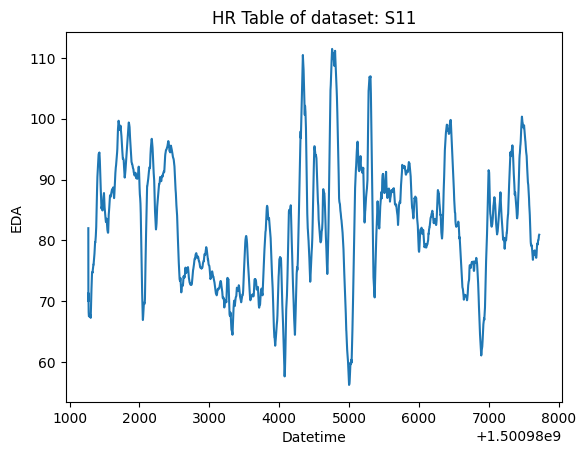

In [143]:
#id of one of the subjects
idx = f'S{11}'

dataset = data[data['id'] == idx]
plt.plot(dataset['datetime'], dataset[f'{signal}'])
plt.title(f'{signal} Table of dataset: ' + f'{idx}')
plt.xlabel('Datetime')
plt.ylabel('EDA')
plt.show()
